In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.utils as util

from sklearn import ensemble
from sklearn.metrics import mean_squared_error

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load datasets
df = [None] * 3
X_df = [None] * 3
Y_df = [None] * 3

files = ["auto-mpg", "housing", "machine"]
y_column = ["mpg", "MEDV", "PRP"]
bad_columns = [["car name"], [], ["vendor name", "Model Name", "ERP"]]
names = [["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"],
         ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"],
         ["vendor name", "Model Name", "MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX", "PRP", "ERP"]]

df[0] = pd.read_csv("datasets/" + files[0] + ".data", delim_whitespace=True, names=names[0])
df[1] = pd.read_csv("datasets/" + files[1] + ".data", delim_whitespace=True, names=names[1])
df[2] = pd.read_csv("datasets/" + files[2] + ".data", sep=',', names=names[2])

for i in xrange(len(df)):
    df[i] = df[i].drop(bad_columns[i], axis=1)
    Y_df[i] = df[i][y_column[i]]
    X_df[i] = df[i].drop(y_column[i], axis=1)
    print files[i] + ":\t%d rows x %d features" % (X_df[i].shape[0], X_df[i].shape[1])

auto-mpg:	398 rows x 7 features
housing:	506 rows x 13 features
machine:	209 rows x 6 features


In [3]:
# Create matrices from dataframes
X = [None] * 3
Y = [None] * 3

for i in xrange(len(df)):
    X[i] = X_df[i].as_matrix()
    Y[i] = Y_df[i].as_matrix()

In [4]:
# Replace missing values in auto-mpg
def replaceMissing(X):
    
    for i in xrange(X.shape[0]):
        for j in xrange(X.shape[1]):
            try:
                X[i, j] = np.float(X[i, j])
            except ValueError:
                X[i, j] = np.nan
    X = np.array(X, dtype=float)
                
    for j in xrange(X.shape[1]):
        col = X[:, j]
        if np.isnan(np.sum(col)):
            col = col[~np.isnan(col)]
            mean_value = np.mean(col)
            for i in xrange(X.shape[0]):
                if np.isnan(X[i, j]):
                    X[i, j] = mean_value
                    print "Auto-MPG dataset: [%d, %d]: from nan to %0.2f" % (i, j, mean_value)
    return X

X[0] = replaceMissing(X[0])

Auto-MPG dataset: [32, 2]: from nan to 104.47
Auto-MPG dataset: [126, 2]: from nan to 104.47
Auto-MPG dataset: [330, 2]: from nan to 104.47
Auto-MPG dataset: [336, 2]: from nan to 104.47
Auto-MPG dataset: [354, 2]: from nan to 104.47
Auto-MPG dataset: [374, 2]: from nan to 104.47


In [5]:
# Decision tree
##################################################
# Calculate impurity in node
def node_impurity(y):
    
    mean = np.mean(y)
    delta = np.subtract(y, mean)
    return np.dot(delta, delta)

# Calculate normalized impurity in node
def node_impurity_norm(y):

    return node_impurity(y) / float(len(y))

# Find impurity after splitting
def impurity_after_split(y, i):

    l_samples = y[:i]
    r_samples = y[i:]
    N_l = i
    N_r = len(y) - i
    
    return N_l * node_impurity_norm(l_samples) + N_r * node_impurity_norm(r_samples)

# Find best split for node
def find_split(node):
    
    new_impurity = +inf
    min_impurity = +inf
    feature = None
    threshold = None
    l_rows = None
    r_rows = None
    
    for j in xrange(node.X.shape[1]):
        x_column = node.X[:, j]
        rows = np.argsort(x_column)
        x_sorted = x_column[rows]
        y_sorted = node.Y[rows]
        
        for i in xrange(1, len(x_sorted)):   
            
            if x_sorted[i] == x_sorted[i - 1]:
                continue
                
            new_impurity = impurity_after_split(y_sorted, i)
            
            if new_impurity < min_impurity:
                min_impurity = new_impurity
                feature = j
                threshold = (x_sorted[i] + x_sorted[i - 1]) / 2.0
                l_rows = rows[:i]
                r_rows = rows[i:]

    return feature, threshold, l_rows, r_rows
    
# Define a tree node
class CNode:
    
    def __init__(self, X, Y, feature=None, threshold=None, depth=0, parent=None):
        
        self.X = X
        self.Y = Y
        self.feature = feature
        self.threshold = threshold
        self.depth = depth
        self.parent = parent
        
        self.impurity = node_impurity_norm(Y)
        self.reduction = None
        self.mean = None
        
    def split(self):

        feature, threshold, l_rows, r_rows = find_split(self)
        
        if feature is not None:
            self.feature = feature
            self.threshold = threshold
            self.reduction = node_impurity(self.Y) - node_impurity(self.Y[l_rows]) - node_impurity(self.Y[r_rows])
            left_node = CNode(self.X[l_rows], self.Y[l_rows], depth=self.depth + 1)
            right_node = CNode(self.X[r_rows], self.Y[r_rows], depth=self.depth + 1)
            
        else:
            left_node = None
            right_node = None
        
        return left_node, right_node
        
# Define a decision tree
class CTree:
    
    def __init__(self, max_depth=3, min_samples_split=2):
        
        self.nodes = []
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
    def fit(self, X, Y):
        
        self.nodes = np.array([CNode(X, Y)])
        self.feature_importances = np.zeros(X.shape[1])
        todo = np.array([0])
        
        while todo.size > 0:
            index = todo[0]
            todo = todo[1:]
            
            if self.nodes[index].depth < self.max_depth and len(self.nodes[index].X) > self.min_samples_split:
                
                left, right = self.nodes[index].split()

                if left is not None:
                    N = len(self.nodes)
                    self.nodes[index].left = N
                    self.nodes[index].right = N + 1
                    left.parent = index
                    right.parent = index
                    self.nodes = np.append(self.nodes, [left, right])
                    feature = self.nodes[index].feature
                    self.feature_importances[feature] += self.nodes[index].reduction
                    todo = np.append(todo, [N, N + 1])
                    continue
                    
            self.nodes[index].mean = np.mean(self.nodes[index].Y)
            self.nodes[index].X = None
            self.nodes[index].Y = None
            
        self.feature_importances = self.feature_importances / float(np.sum(self.feature_importances))
                
        return self
        
    def predict(self, X):
        
        answer = np.zeros(X.shape[0])
        
        if len(self.nodes) == 0:
            return answer
        
        for i in xrange(X.shape[0]):
            index = 0
            
            while self.nodes[index].mean is None:
                feature = self.nodes[index].feature
                threshold = self.nodes[index].threshold
                if X[i, feature] <= threshold:
                    index = self.nodes[index].left
                else:
                    index = self.nodes[index].right
            answer[i] = self.nodes[index].mean
            
        return answer

In [6]:
# Stochastic gradient boosting
##################################################
# Sampling
def sampleData(X, Y, sample):
    
    x, y = util.shuffle(X, Y)
    offset = int(x.shape[0] * sample)
    
    return x[:offset], y[:offset]

# Define regressor class
class MyRegressor:
    
    def __init__(self, n_estimators=100, max_depth=3, min_samples_split=2, learning_rate=0.1, subsample=0.5, verbose=0):
        
        self.n_estimators = n_estimators
        self.estimators = [None] * n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.verbose = verbose
        self.h = [0] * n_estimators
        
    def fit(self, X, Y):
        
        if self.verbose == 1:
            print "Iter\tTrain Loss"
        
        self.init_value = np.mean(Y)
        initial = np.empty(X.shape[0])
        initial.fill(self.init_value)
        self.loss = np.zeros(self.n_estimators)
        self.feature_importances = np.zeros(X.shape[1])
        
        for i in xrange(self.n_estimators):

            if i == 0:
                prev = initial
            else:
                prev = self.h[i - 1]
                
            G = Y - prev
            x, g = sampleData(X, G, self.subsample)
            
            self.estimators[i] = CTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            self.estimators[i].fit(x, g)
            self.feature_importances += self.learning_rate * self.estimators[i].feature_importances
            self.h[i] = prev + self.learning_rate * self.estimators[i].predict(X)
            self.loss[i] = mean_squared_error(self.h[i], Y)
               
            if self.verbose == 1:
                if i <= 10 or i % 10 == 0:
                    print "%d\t%0.4f" % (i, self.loss[i])
                    
        self.feature_importances = self.feature_importances / float(np.sum(self.feature_importances))
        
        return self
        
    def predict(self, X, Y=None):

        answer = np.empty(X.shape[0])
        answer.fill(self.init_value)
        
        if Y is not None:
            self.test_loss = np.zeros(self.n_estimators)
        
        for i in xrange(self.n_estimators):
            answer += self.learning_rate * self.estimators[i].predict(X)
            
            if Y is not None:
                self.test_loss[i] = mean_squared_error(answer, Y)

        return answer

In [7]:
# Run regressors
train_size = 0.8
params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.5, 'verbose': 0}
loss = np.zeros((len(X), 2, params['n_estimators']))
test_loss = np.zeros((len(X), params['n_estimators']))

for i in xrange(len(X)):
    x, y = util.shuffle(X[i], Y[i])
    offset = int(x.shape[0] * train_size)
    X_train, Y_train = x[:offset], y[:offset]
    X_test, Y_test = x[offset:], y[offset:]
    print "Dataset %d:" % i
    print "\tTrain set: %d rows\n\tTest set: %d rows" % (X_train.shape[0], X_test.shape[0])
    
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, Y_train)
    mse = mean_squared_error(reg.predict(X_test), Y_test)
    loss[i, 0] = reg.train_score_
    
    my_reg = MyRegressor(**params)
    my_reg.fit(X_train, Y_train)
    my_mse = mean_squared_error(my_reg.predict(X_test, Y_test), Y_test)
    loss[i, 1] = my_reg.loss
    test_loss[i] = my_reg.test_loss
    
    print "\tMean squared error: %0.4f (sklearn), %0.4f (mine)" % (mse, my_mse)

Dataset 0:
	Train set: 318 rows
	Test set: 80 rows
	Mean squared error: 8.6814 (sklearn), 8.8742 (mine)
Dataset 1:
	Train set: 404 rows
	Test set: 102 rows
	Mean squared error: 8.0686 (sklearn), 9.0597 (mine)
Dataset 2:
	Train set: 167 rows
	Test set: 42 rows
	Mean squared error: 3559.1308 (sklearn), 3503.6865 (mine)


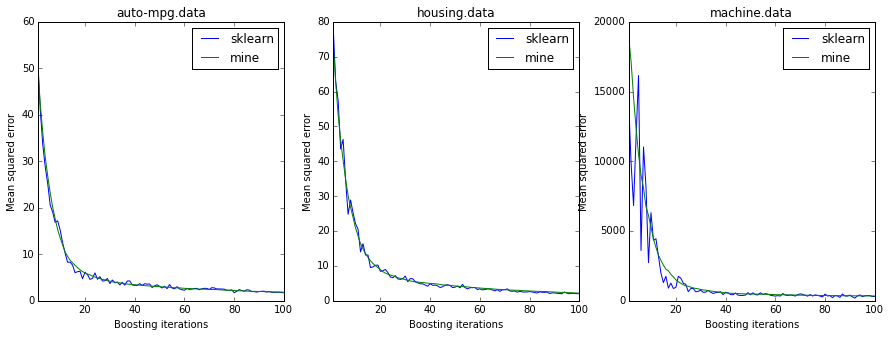

In [8]:
# Plot train loss
pl.figure(figsize=(15, 5))

N = params['n_estimators']
t = np.linspace(1, N, N, endpoint=True)

for i in xrange(len(X)):
    pl.subplot(1, len(X), i + 1)
    reg_loss, = pl.plot(t, loss[i][0], color="blue", linewidth=1.0, linestyle="-")
    my_reg_loss, = pl.plot(t, loss[i][1], color="green", linewidth=1.0, linestyle="-")
    pl.xlim(1, N)
    pl.title(files[i] + ".data")
    pl.legend([reg_loss, my_reg_loss], ['sklearn', 'mine'])
    pl.xlabel("Boosting iterations")
    pl.ylabel("Mean squared error")

pl.show()

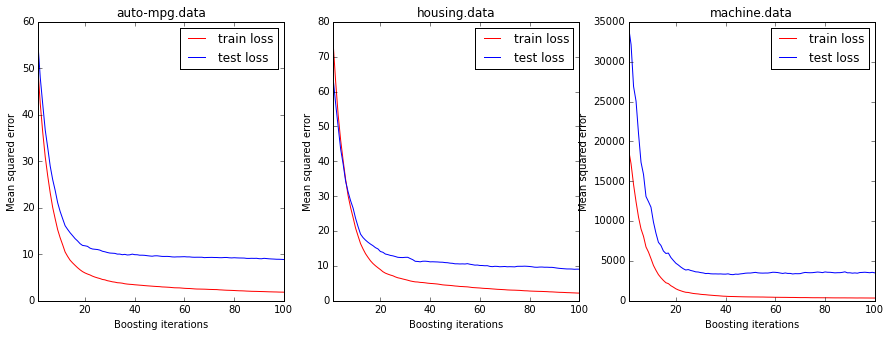

In [9]:
# Plot test loss
pl.figure(figsize=(15, 5))

N = params['n_estimators']
t = np.linspace(1, N, N, endpoint=True)

for i in xrange(len(X)):
    pl.subplot(1, len(X), i + 1)
    train, = pl.plot(t, loss[i][1], color="red", linewidth=1.0, linestyle="-")
    test, = pl.plot(t, test_loss[i], color="blue", linewidth=1.0, linestyle="-")
    pl.xlim(1, N)
    pl.title(files[i] + ".data")
    pl.legend([train, test], ['train loss', 'test loss'])
    pl.xlabel("Boosting iterations")
    pl.ylabel("Mean squared error")

pl.show()

In [10]:
# Try with different params
learning_rate = [1, 0.1, 1, 0.1]
subsample = [1, 1, 0.5, 0.5]

loss_param = np.zeros((len(X), len(learning_rate), params['n_estimators']))

for i in xrange(len(X)):
    x, y = util.shuffle(X[i], Y[i])
    offset = int(x.shape[0] * train_size)
    X_train, Y_train = x[:offset], y[:offset]
    X_test, Y_test = x[offset:], y[offset:]
    print "Dataset %d:" % i
    print "\tTrain set: %d rows\n\tTest set: %d rows" % (X_train.shape[0], X_test.shape[0])
    
    for j in xrange(len(learning_rate)):
        params['learning_rate'] = learning_rate[j]
        params['subsample'] = subsample[j]
    
        reg = MyRegressor(**params)
        reg.fit(X_train, Y_train)
        mse = mean_squared_error(reg.predict(X_test, Y_test), Y_test)
        loss_param[i, j] = reg.test_loss
    
        print "\tShrink = %0.1f, Sample = %0.1f, MSE = %0.4f" % (learning_rate[j], subsample[j], mse)

Dataset 0:
	Train set: 318 rows
	Test set: 80 rows
	Shrink = 1.0, Sample = 1.0, MSE = 13.3984
	Shrink = 0.1, Sample = 1.0, MSE = 9.6680
	Shrink = 1.0, Sample = 0.5, MSE = 45.4911
	Shrink = 0.1, Sample = 0.5, MSE = 10.4592
Dataset 1:
	Train set: 404 rows
	Test set: 102 rows
	Shrink = 1.0, Sample = 1.0, MSE = 23.0712
	Shrink = 0.1, Sample = 1.0, MSE = 8.8315
	Shrink = 1.0, Sample = 0.5, MSE = 70.2494
	Shrink = 0.1, Sample = 0.5, MSE = 9.9957
Dataset 2:
	Train set: 167 rows
	Test set: 42 rows
	Shrink = 1.0, Sample = 1.0, MSE = 1779.3620
	Shrink = 0.1, Sample = 1.0, MSE = 1637.8439
	Shrink = 1.0, Sample = 0.5, MSE = 4118.6441
	Shrink = 0.1, Sample = 0.5, MSE = 1631.4085


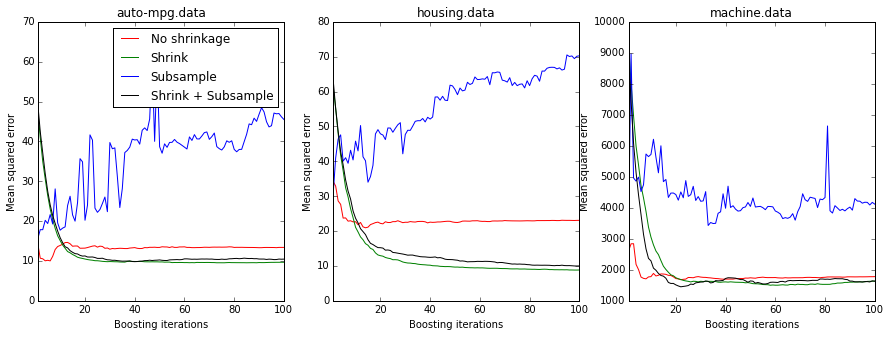

In [11]:
# Plot loss with different params
pl.figure(figsize=(15, 5))

N = params['n_estimators']
t = np.linspace(1, N, N, endpoint=True)
colors = ["red", "green", "blue", "black"]
legend = ["No shrinkage", "Shrink", "Subsample", "Shrink + Subsample"]

for i in xrange(len(X)):
    pl.subplot(1, len(X), i + 1)
    
    for j in xrange(len(learning_rate)):
        pl.plot(t, loss_param[i][j], color=colors[j], linewidth=1.0, linestyle="-")
        
    pl.xlim(1, N)
    pl.title(files[i] + ".data")  
    pl.xlabel("Boosting iterations")
    pl.ylabel("Mean squared error")
    if i == 0:
        pl.legend(legend)

pl.show()